In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import os
from google.colab import userdata
import pandas as pd
import random
import math
import random
import folium

def get_api_key():
    return userdata.get('google_maps_api')

In [ ]:
#@title Setting keys
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
#os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')
#os.environ['REPLICATE_API_TOKEN'] = userdata.get('REPLICATE_API_KEY')
os.environ['GEMINI_API_KEY'] = userdata.get('GEMINI_API_KEY')
os.environ['GOOGLE_MAPS_API_KEY'] = userdata.get('google_maps_api')

TimeoutException: Requesting secret OPENAI_API_KEY timed out. Secrets can only be fetched when running from the Colab UI.

In [ ]:
!pip install openai anthropic replicate google-generativeai --quiet

In [ ]:
#@title Cloning dataset
#!gdown --id '1AY8SvhaFkfLNcpr_xITB7NATnTGmi7cC' --folder
!gdown --id '1FodVI-dir7zIpGRVpjnRBgvyTILAOFCX' --folder
#!unzip dataset_v2/imgs_v2.zip -d dataset_v2
!unzip dataset_final_v1/imgs_final_v1.zip -d dataset_final_v1




/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Processing file 1B_u-oW9YGNCsOI6Uxi9XcCmaTlWLSxf- 20percent__of_benchmark.csv
Processing file 1UdLV7U9eRFkgQcavl03GA6x1jkZpLsCZ img_coordinates_final_v1_with_country.csv
Processing file 1AAAbMBNCoEuq7KceH7L0At1G6VyQcFbP img_coordinates_final_v1.csv
Processing file 1r_PEgSr6YNBfZ3DQoSyg0o92XIkwsHFz imgs_final_v1.zip
Processing file 1GTAP0QlsRJJXhRb60rsBgS1dsU5MomYD sampled_cities_v1.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1B_u-oW9YGNCsOI6Uxi9XcCmaTlWLSxf-
To: /content/dataset_final_v1/20percent__of_benchmark.csv
100% 26.2k/26.2k [00:00<00:00, 36.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UdLV7U9eRFkgQcavl03G

In [ ]:
#@title Get image names
import pandas as pd
df = pd.read_csv('/content/dataset_final_v1/img_coordinates_final_v1_with_country.csv')
image_names = df['filename'].tolist()
df.head()

import os

image_dir = '/content/dataset_final_v1/imgs_final_v1'
num_pictures = len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])

print(f"Number of pictures in the directory: {num_pictures}")

Number of pictures in the directory: 1602


In [ ]:
df.head()

,filename,city_name,lat,lng,heading,country
0,imgs_final_v1/0.jpg,Geelong,-38.148907,144.348668,343,Australia
1,imgs_final_v1/1.jpg,Townsville,-19.249273,146.817089,51,Australia
2,imgs_final_v1/2.jpg,Tauranga,-37.683999,176.167290,185,New Zealand
3,imgs_final_v1/3.jpg,Cairns,-16.919275,145.778679,341,Australia
4,imgs_final_v1/4.jpg,Darwin,-12.437700,130.840366,73,Australia


In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import os
from google.colab import userdata
import pandas as pd
import random
import math
import json
import re
import base64
from datetime import datetime
import openai
import traceback
import google.generativeai as genai

In [ ]:
def get_streetview_image(lat,long,heading,pitch):
  response = requests.get(f"https://maps.googleapis.com/maps/api/streetview?size=640x640&radius=500&location={lat},{long}&fov=100&heading={heading}&pitch={pitch}&key={os.environ['GOOGLE_MAPS_API_KEY']}")

  if response.status_code == 200:
      print(f"Request successful for image ({lat},{long}), at heading {heading}, pitch {pitch}")

      img = Image.open(BytesIO(response.content))
      return img
      plt.imshow(img)
  else:
      print(f"Error: {response.content}")

Request successful for image (5.666918789759198,-0.015973476952908), at heading -40, pitch 0


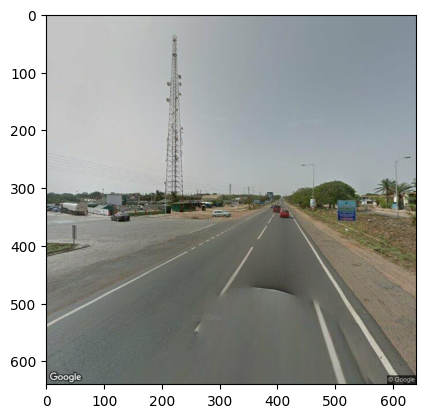

In [ ]:
image = get_streetview_image(5.666918789759198,-0.015973476952908,-40,0)
plt.imshow(image)

path = '/content/test.jpg'
image.save(path)

In [ ]:
#imshow 931


In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance between two sets of coordinates using the Haversine formula.

    Args:
        lat1 (float): Latitude of the first set of coordinates.
        lon1 (float): Longitude of the first set of coordinates.
        lat2 (float): Latitude of the second set of coordinates.
        lon2 (float): Longitude of the second set of coordinates.

    Returns:
        float: The distance between the two sets of coordinates in kilometers.
    """
    R = 6371  # Earth's radius in kilometers

    # Convert degrees to radians
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Calculate the Haversine formula
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

def get_cardinal_direction(heading):
    """Convert heading degrees to cardinal direction."""
    directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    index = round(heading / 45) % 8
    return directions[index]

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def fix_json_string(string_test):
    try:
        # Try to parse the string as JSON
        json.loads(string_test)
        # If successful, the string is already valid JSON, so return it unchanged
        return string_test
    except json.JSONDecodeError:
        # If parsing fails, attempt to fix the string

        # Use regex to find unquoted values for any key
        pattern = r'("(?:lat|long|city|country|[^"]+)":\s*)([^",\}\]]+)(?=[,\}\]])'

        def add_quotes(match):
            key = match.group(1)
            value = match.group(2).strip()

            # Check if the value is a number
            if re.match(r'^-?\d+(\.\d+)?$', value):
                return f'{key}{value}'
            else:
                # If it's not a number, add quotes
                return f'{key}"{value}"'

        # Apply the regex substitution
        fixed_string = re.sub(pattern, add_quotes, string_test)

        try:
            # Try to parse the fixed string
            json.loads(fixed_string)
            # If successful, return the fixed string
            return fixed_string
        except json.JSONDecodeError:
            # If still invalid, return the original string
            return string_test


In [ ]:
def response_openai(api_key, message_history):
    openai_client = openai.OpenAI(api_key=api_key)
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=message_history,
        max_tokens=1024,
        temperature=0
    )
    return response.choices[0].message.content

def response_gemini(api_key, message_history):
    """
    Handle communication with Gemini 1.5 Pro API.
    """
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-1.5-pro')

    # Extract the latest message and image from history
    latest_message = message_history[-1]

    # Check if this is an image message
    if isinstance(latest_message["content"], list):
        # Get the text prompt and image path
        prompt = latest_message["content"][0]["text"]
        image_path = latest_message["content"][1]["image_url"]["url"]

        # Convert base64 image URL to PIL Image
        if image_path.startswith('data:image/jpeg;base64,'):
            img_data = base64.b64decode(image_path.split(',')[1])
            img = Image.open(BytesIO(img_data))
        else:
            img = Image.open(image_path)

        # Create the message parts
        parts = [prompt, img]

        # Add context from previous messages if they exist
        context = ""
        if len(message_history) > 1:
            for msg in message_history[:-1]:
                if msg["role"] == "assistant":
                    context += f"Previous response: {msg['content']}\n"
                elif msg["role"] == "user" and isinstance(msg["content"], str):
                    context += f"Previous request: {msg['content']}\n"

        if context:
            parts.insert(0, f"Context from previous interactions:\n{context}\n")
    else:
        # Text-only message
        parts = [latest_message["content"]]

    try:
        response = model.generate_content(parts, stream=False)
        return response.text
    except Exception as e:
        print(f"Error in Gemini API call: {str(e)}")
        return None


In [ ]:
# Initial prompt for first image
geoguessr_prompt = """
You are a top-ranked, professional, competitive world-class GeoGuessr player, renowned for your ability to accurately pinpoint the location of images based solely on the visual clues they provide. You have a keen eye for detail and an extensive knowledge of geography that allows you to make insightful deductions.

You have been presented with a new image, and your task is to use your exceptional skills to determine the precise coordinates of the location depicted. Carefully examine the image, taking note of any distinctive features, landmarks, vegetation, or other elements that could serve as clues. Piece together a chain of thought, step by step, to infer the most likely location.

After analyzing this initial view, you can request additional views from the same location by specifying new camera parameters:

- Heading (0 - 360): direction camera is pointing, e.g. north, west, south, east
- Pitch (-90 - 90): vertical angle of the camera relative to ground

Choose your camera movements strategically - look for signs, landmarks, or geographic features that could help refine your guess.

Make your initial guess based on what you see, but plan what additional views would be most helpful for your next guess.

Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.

NOTE: PROVIDE ONLY 1 JSON OBJECT for each guess and API parameters in the format below

{"lat": latitude, "long": longitude, "city": city, "country": country, "heading": heading, "pitch": pitch}
"""

# Updated continuation prompt
def get_continuation_prompt(previous_views, heading, cardinal_direction, pitch):
    prompt =  f"""
    Please continue with your guesses.

    You've seen {previous_views} views of this location. Use the information from all previous images plus this new view to refine your guess.

    Current image parameters:
    - Heading: {heading}° ({cardinal_direction})
    - Pitch: {pitch}°

    You can request another view of this location by specifying new camera parameters:
    - Heading (0 - 360): Choose a direction that might reveal more useful clues
    - Pitch (-90 - 90): Look up or down to spot additional details

    Think strategically about what angles might provide the most valuable new information to improve your guess.

    Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.

    """
    return prompt.strip() + """
    NOTE: PROVIDE ONLY 1 JSON OBJECT for each guess and API parameters in the format below:
    {"lat": latitude, "long": longitude, "city": city, "country": country, "heading": heading, "pitch": pitch}
    """


In [ ]:
def process_image(csv_row, output_folder, gemini_api_key, google_api_key):
    filename, city_name, label_lat, label_lng, heading, country = csv_row
    pitch = 0

    messages_history = []

    results = {
        'filename': filename,
        'label_city_name': city_name,
        'label_country': country,
        'label_lat': label_lat,
        'label_lng': label_lng
    }

    print(f"\nProcessing image: {filename}")
    print(f"Label: {city_name}, {country}, coords: ({label_lat}, {label_lng})")

    for i in range(5):
        if i == 0:
            prompt = geoguessr_prompt
            full_image_path = os.path.join('/content/dataset_final_v1/', filename)
            print(f"Processing image: {full_image_path}")
        else:
            prompt = get_continuation_prompt(i, heading, get_cardinal_direction(heading), pitch)
            full_image_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_guess_{i}.jpg")
            print(f"Processing image: {full_image_path}")

        base64_image = encode_image(full_image_path)

        messages_history.append({
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
            ]
        })

        response = response_gemini(gemini_api_key, messages_history)

        if response:
            messages_history.append({
                "role": "assistant",
                "content": response,
            })

            print(f"\nGuess {i+1} Response:")
            print(response)

            start = response.find('{')
            end = response.find('}') + 1

            json_str = response[start:end]
            json_str = fix_json_string(json_str)

            if json_str:
                print(f"json output: {json_str}")
                data = json.loads(json_str)

                guess_lat = float(data['lat'])
                guess_lng = float(data['long'])
                distance = calculate_distance(float(label_lat), float(label_lng), guess_lat, guess_lng)

                results[f'guess_{i+1}_city_name'] = data['city']
                results[f'guess_{i+1}_country'] = data['country']
                results[f'guess_{i+1}_lat'] = data['lat']
                results[f'guess_{i+1}_lng'] = data['long']
                results[f'guess_{i+1}_heading'] = data['heading']
                results[f'guess_{i+1}_pitch'] = data['pitch']
                results[f'guess_{i+1}_distance'] = distance
                results[f'guess_{i+1}_response'] = response

                new_image = get_streetview_image(label_lat, label_lng, data['heading'], data['pitch'])

                img_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_guess_{i+1}.jpg")
                new_image.save(img_path)

                print(f"Saved image: {img_path}")
                print(f"\nStreet View image for guess {i+1}:")
                plt.imshow(new_image)
            else:
                print("No JSON object found in the response.")
                results[f'guess_{i+1}_city_name'] = "N/A"
                results[f'guess_{i+1}_country'] = "N/A"
                results[f'guess_{i+1}_lat'] = "N/A"
                results[f'guess_{i+1}_lng'] = "N/A"
                results[f'guess_{i+1}_heading'] = "N/A"
                results[f'guess_{i+1}_pitch'] = "N/A"
                results[f'guess_{i+1}_distance'] = "N/A"
                results[f'guess_{i+1}_response'] = response
        else:
            print("Failed to get response from Gemini API")
            results[f'guess_{i+1}_city_name'] = "N/A"
            results[f'guess_{i+1}_country'] = "N/A"
            results[f'guess_{i+1}_lat'] = "N/A"
            results[f'guess_{i+1}_lng'] = "N/A"
            results[f'guess_{i+1}_heading'] = "N/A"
            results[f'guess_{i+1}_pitch'] = "N/A"
            results[f'guess_{i+1}_distance'] = "N/A"
            results[f'guess_{i+1}_response'] = "API Error"

    return results


In [ ]:
def run_geoguessr_test(csv_path, start_row=0, end_row=2):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_folder = f'test_output_{timestamp}'
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'imgs_final_v1'), exist_ok=True)

    df = pd.read_csv(csv_path)
    test_rows = df.iloc[start_row:end_row+1]

    gemini_api_key = os.environ.get('GEMINI_API_KEY')
    google_api_key = os.environ.get('GOOGLE_MAPS_API_KEY')

    all_results = []

    for idx, row in test_rows.iterrows():
        print("\n" + "="*50)
        print(f"Testing image {idx+1} of {end_row-start_row+1}")
        print("="*50)

        row_data = [
            row['filename'],
            row['city_name'],
            row['lat'],
            row['lng'],
            row['heading'],
            row['country']
        ]

        try:
            results = process_image(
                row_data,
                output_folder,
                gemini_api_key,
                google_api_key
            )

            all_results.append(results)

            print("\nResults Summary:")
            print(f"True Location: {results['label_city_name']}, {results['label_country']}")
            print(f"Coordinates: ({results['label_lat']}, {results['label_lng']})")
            print("\nGuesses:")

            for i in range(1, 6):
                guess_prefix = f'guess_{i}'
                if f'{guess_prefix}_city_name' in results:
                    if results[f'{guess_prefix}_city_name'] != "N/A":
                        print(f"\nGuess {i}:")
                        print(f"Location: {results[f'{guess_prefix}_city_name']}, {results[f'{guess_prefix}_country']}")
                        print(f"Coordinates: ({results[f'{guess_prefix}_lat']}, {results[f'{guess_prefix}_lng']})")
                        print(f"Distance from true location: {results[f'{guess_prefix}_distance']:.2f} km")
                        print(f"Heading: {results[f'{guess_prefix}_heading']}°")
                        print(f"Pitch: {results[f'{guess_prefix}_pitch']}°")
                    else:
                        print(f"\nGuess {i}: Failed to parse response")

        except Exception as e:
            print(traceback.format_exc())
            print(f"Error processing image {row['filename']}: {str(e)}")
            continue

    results_df = pd.DataFrame(all_results)

    required_columns = [
        'filename', 'label_city_name', 'label_country', 'label_lat', 'label_lng'
    ]

    for i in range(1, 6):
        prefix = f'guess_{i}'
        required_columns.extend([
            f'{prefix}_city_name', f'{prefix}_country', f'{prefix}_lat', f'{prefix}_lng',
            f'{prefix}_heading', f'{prefix}_pitch', f'{prefix}_distance', f'{prefix}_response'
        ])

    for col in required_columns:
        if col not in results_df.columns:
            results_df[col] = 'N/A'

    results_df = results_df[required_columns]

    csv_output_path = os.path.join(output_folder, f'results_{timestamp}.csv')
    results_df.to_csv(csv_output_path, index=False)
    print(f"\nResults saved to: {csv_output_path}")
    # download
    from google.colab import files
    files.download(csv_output_path)

    return results_df


In [ ]:
csv_path = '/content/dataset_final_v1/20percent__of_benchmark.csv'
results_df = run_geoguessr_test(csv_path, start_row=0, end_row=100)
print(results_df.head())


Testing image 1 of 101

Processing image: imgs_final_v1/1170.jpg
Label: Cilacap, Indonesia, coords: (-7.717314555026571, 109.01637984351288)
Processing image: /content/dataset_final_v1/imgs_final_v1/1170.jpg


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def analyze_geoguessr_results(results_df):
    for i in range(1, 6):
        col = f'guess_{i}_distance'
        results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

    data_for_plot = []
    labels = []
    for i in range(1, 6):
        distances = results_df[f'guess_{i}_distance'].dropna()
        data_for_plot.append(distances)
        labels.append(f'Guess {i}')

    plt.figure(figsize=(10, 6))
    box_plot = plt.boxplot(data_for_plot, labels=labels, patch_artist=True)

    colors = ['lightblue', 'lightgreen', 'pink', 'lightyellow', 'lightgray']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)

    plt.title('Distance Distribution for Each Guess')
    plt.ylabel('Distance (km)')
    plt.xlabel('Guess Number')
    plt.grid(True, linestyle='--', alpha=0.7)

    stats = {
        'guess_number': [],
        'avg_distance': [],
        'median_distance': [],
        'min_distance': [],
        'max_distance': [],
        'std_distance': []
    }

    for i in range(1, 6):
        distances = results_df[f'guess_{i}_distance'].dropna()
        stats['guess_number'].append(i)
        stats['avg_distance'].append(distances.mean())
        stats['median_distance'].append(distances.median())
        stats['min_distance'].append(distances.min())
        stats['max_distance'].append(distances.max())
        stats['std_distance'].append(distances.std())

    stats_df = pd.DataFrame(stats)

    best_guesses = []
    for _, row in results_df.iterrows():
        distances = [row[f'guess_{i}_distance'] for i in range(1, 6)]
        distances = [d for d in distances if pd.notna(d)]  # Remove NaN values
        if distances:  # If there are any valid distances
            best_guesses.append(min(distances))

    best_guess_stats = {
        'Average of Best Guesses': np.mean(best_guesses),
        'Median of Best Guesses': np.median(best_guesses),
        'Min of Best Guesses': np.min(best_guesses),
        'Max of Best Guesses': np.max(best_guesses),
        'Std of Best Guesses': np.std(best_guesses)
    }

    print("\nGuess Statistics:")
    print(stats_df.round(2).to_string(index=False))

    print("\nBest Guess Statistics:")
    for metric, value in best_guess_stats.items():
        print(f"{metric}: {value:.2f} km")

    plt.show()

    return stats_df, best_guess_stats

# Run the analysis
stats_df, best_guess_stats = analyze_geoguessr_results(results_df)

NameError: name 'results_df' is not defined

In [ ]:
# download csv file
dir = '/content/test_output_20241120_190635'

from google.colab import files
# download all csv files in that dir
import os
import glob
import pandas as pd

# Get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(dir, '*.csv'))

# download
for csv_file in csv_files:
    files.download(csv_file)
    print(f"Downloaded: {csv_file}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: /content/test_output_20241120_190635/results_20241120_190635.csv


# Geocoding Tool Use

In [ ]:
def extract_json_from_response(response):
    """
    Extract and parse JSON from model response string.

    Args:
        response (str or dict): Model response, either as string or dictionary

    Returns:
        dict: Parsed JSON data or None if extraction fails
    """
    try:
        # Handle OpenAI response format
        if isinstance(response, dict):
            if 'choices' in response:
                text_content = response['choices'][0]['message']['content']
            else:
                text_content = response.get('content', response)
        else:
            text_content = response

        # Find JSON object in the text
        start = text_content.find('{')
        end = text_content.find('}') + 1

        if start == -1 or end == 0:
            return None

        json_str = text_content[start:end]
        json_str = fix_json_string(json_str)

        if json_str:
            try:
                return json.loads(json_str)
            except json.JSONDecodeError:
                print("Failed to parse JSON after fixing")
                return None
        return None

    except Exception as e:
        print(f"Error extracting JSON: {str(e)}")
        return None


In [ ]:
!pip install googlemaps

In [ ]:
import pandas as pd
import time
import json
import os
from datetime import datetime
from googlemaps import Client

In [ ]:
def get_coordinates_from_region(gmaps_client, region, city, country):
    """
    Get coordinates using Google Geocoding API for a region description.

    Args:
        gmaps_client: Initialized Google Maps client
        region (str): Region description (neighborhood, landmark, etc.)
        city (str): City name
        country (str): Country name

    Returns:
        tuple: (latitude, longitude) or (None, None) if geocoding fails
    """
    try:
        # Combine location components into a search string
        search_query = f"{region}, {city}, {country}"

        # Get geocoding results
        result = gmaps_client.geocode(search_query)

        if result and len(result) > 0:
            location = result[0]['geometry']['location']
            return location['lat'], location['lng']
        return None, None
    except Exception as e:
        print(f"Geocoding error: {str(e)}")
        return None, None

In [ ]:
gmaps = Client(key=os.environ['GOOGLE_MAPS_API_KEY'])

In [ ]:
get_coordinates_from_region(gmaps, '', 'New York', 'USA')

(40.7127753, -74.0059728)

In [ ]:
def response_openai(api_key, prompt, filename):
    openai_client = openai.OpenAI()
    base64_image = encode_image(filename)

    headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }

        # Construct the payload
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ],

            }
        ],
        "max_tokens": 1024,
        "temperature": 0,
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()['choices'][0]['message']['content']


In [ ]:
def get_initial_prompt():
    initial_prompt = """
    You are a top-ranked, professional, competitive world-class GeoGuessr player, renowned for your ability to accurately pinpoint the location of images based solely on the visual clues they provide. You have a keen eye for detail and an extensive knowledge of geography that allows you to make insightful deductions.

    You have been presented with a new image, and your task is to use your exceptional skills to determine the precise coordinates of the location depicted. Carefully examine the image, taking note of any distinctive features, landmarks, vegetation, or other elements that could serve as clues. Piece together a chain of thought, step by step, to infer the most likely location.

    Once you have gathered sufficient evidence, provide your best guess for the coordinates in the following JSON format:

    {"region": "specific area/neighborhood/landmark", "city": "city name", "country": "country name",
     "lat": latitude, "long": longitude}

    If you cannot narrow it down, then provide your best guess.

    Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.
    """
    return initial_prompt

def get_revision_prompt(lat, long, region, city, country):
    revision_prompt = f"""
    Here are the geocoded coordiantes {lat}, {long} for your suggested region "{region}" in {city}, {country}, as provided by the Google Geocoding API.
    With this information, you can choose to either modify, finetune, or keep your first guess. In any case, please provide your final best guess for the coordinates in the following JSON format:
    """

    return revision_prompt + """
    {"lat": revised_latitude, "long": revised_longitude, "region": "region", "city": "city", "country": "country"}
    """


In [ ]:
def get_batch_indices(total_length, num_batches=6):
    """
    Divide the dataset into equal batches and return start/end indices for each batch.

    Returns:
        List of tuples (batch_num, start_idx, end_idx)
    """
    batch_size = total_length // num_batches
    batches = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size if i < num_batches - 1 else total_length
        batches.append((i + 1, start_idx, end_idx))

    return batches

# Display batch information
def show_batch_info(num_batches=6):
    """Show the image ranges for each batch."""
    csv_path = '/content/dataset_final_v1/20percent__of_benchmark.csv'
    df = pd.read_csv(csv_path)
    batches = get_batch_indices(len(df), num_batches)

    print("\nBatch Information:")
    print("=" * 50)
    for batch_num, start_idx, end_idx in batches:
        print(f"Batch {batch_num}: Images {start_idx} to {end_idx} (Total: {end_idx - start_idx})")
    print("\nTo run a specific batch:")
    print("run_llava_batch(batch_num=X)  # where X is the batch number")

# Example usage:
# First, show batch information
show_batch_info()

# Then run a specific batch



Batch Information:
Batch 1: Images 0 to 53 (Total: 53)
Batch 2: Images 53 to 106 (Total: 53)
Batch 3: Images 106 to 159 (Total: 53)
Batch 4: Images 159 to 212 (Total: 53)
Batch 5: Images 212 to 265 (Total: 53)
Batch 6: Images 265 to 319 (Total: 54)

To run a specific batch:
run_llava_batch(batch_num=X)  # where X is the batch number


In [ ]:
def collect_model_data_with_region(image_names, df, gmaps_client, model_type="openai", start_idx=0, end_idx=None):
    """
    Collect two-step predictions from LLaVA model using region-based guessing.
    """
    if end_idx is None:
        end_idx = len(image_names)

    results_data = []

    # First prompt for region-based prediction
    initial_prompt = get_initial_prompt()


    for i in range(start_idx, end_idx):
        filename = f'/content/dataset_final_v1/{image_names[i]}'
        print(f"\nProcessing image: {filename}")

        # Progress bar
        percent_complete = ((i + 1 - start_idx) / (end_idx - start_idx)) * 100
        bar_length = 20
        filled_length = int(bar_length * (i + 1 - start_idx) // (end_idx - start_idx))
        bar = '=' * filled_length + '-' * (bar_length - filled_length)
        print(f'\rProgress: [{bar}] {percent_complete:.1f}%')

        try:
            # Get first prediction with region
            # if model_type == "replicate":
            #     initial_response = response_replicate(os.environ['REPLICATE_API_TOKEN'], initial_prompt, filename, model='llava-13b')
            # Add other model types as needed

            initial_response = response_openai(os.environ['OPENAI_API_KEY'], initial_prompt, filename)
            print(initial_response)

            # Extract JSON from first response
            initial_json = extract_json_from_response(initial_response)

            if initial_json:
                # Get geocoded coordinates
                geocoded_lat, geocoded_lng = get_coordinates_from_region(
                    gmaps_client,
                    initial_json.get('region'),
                    initial_json.get('city'),
                    initial_json.get('country')
                )

                # Get second prediction with geocoded coordinates
                if geocoded_lat and geocoded_lng:
                    formatted_revision_prompt = get_revision_prompt(
                        geocoded_lat,
                        geocoded_lng,
                        initial_json.get('region'),
                        initial_json.get('city'),
                        initial_json.get('country')
                    )

                    # if model_type == "replicate":
                    #     revision_response = response_replicate(
                    #         os.environ['REPLICATE_API_TOKEN'],
                    #         formatted_revision_prompt,
                    #         filename,
                    #         model='llava-13b'
                    #     )
                    revision_response = response_openai(os.environ['OPENAI_API_KEY'], initial_prompt, filename)


                    revision_json = extract_json_from_response(revision_response)
                else:
                    revision_json = None

            # Get ground truth
            label_row = df[df['filename'] == image_names[i]].iloc[0]

            # Store results
            results_data.append({
                'image_name': image_names[i],
                'initial_response': initial_response,
                'initial_region': initial_json.get('region') if initial_json else None,
                'initial_city': initial_json.get('city') if initial_json else None,
                'initial_country': initial_json.get('country') if initial_json else None,
                'initial_lat': initial_json.get('lat') if initial_json else None,
                'initial_long': initial_json.get('long') if initial_json else None,
                'geocoded_lat': geocoded_lat,
                'geocoded_lng': geocoded_lng,
                'revision_response': revision_response if 'revision_response' in locals() else None,
                'revised_region': revision_json.get('region') if revision_json else None,
                'revised_city': revision_json.get('city') if revision_json else None,
                'revised_country': revision_json.get('country') if revision_json else None,
                'revised_lat': revision_json.get('lat') if revision_json else None,
                'revised_long': revision_json.get('long') if revision_json else None,
                'label_city': label_row['city_name'],
                'label_country': label_row['country'],
                'label_lat': label_row['lat'],
                'label_long': label_row['lng'],
                'initial_distance': calculate_distance(
                    label_row['lat'], label_row['lng'],
                    initial_json.get('lat'), initial_json.get('long')
                ) if initial_json else None,
                'geocoded_distance': calculate_distance(
                    label_row['lat'], label_row['lng'],
                    geocoded_lat, geocoded_lng
                ) if geocoded_lat and geocoded_lng else None,
                'revised_distance': calculate_distance(
                    label_row['lat'], label_row['lng'],
                    revision_json.get('lat'), revision_json.get('long')
                ) if revision_json else None
            })

            # print all three distances
            print(f"Initial distance: {results_data[-1]['initial_distance']}")
            print(f"Geocoded distance: {results_data[-1]['geocoded_distance']}")
            print(f"Revised distance: {results_data[-1]['revised_distance']}")
            print("=" * 50)

        except Exception as e:
            print(f"Error processing image {image_names[i]}: {str(e)}")
            # Add error case to results
            label_row = df[df['filename'] == image_names[i]].iloc[0]
            results_data.append({
                'image_name': image_names[i],
                'initial_response': f"Error: {str(e)}",
                'initial_region': None,
                'initial_city': None,
                'initial_country': None,
                'initial_lat': None,
                'initial_long': None,
                'geocoded_lat': None,
                'geocoded_lng': None,
                'revision_response': None,
                'revised_region': None,
                'revised_city': None,
                'revised_country': None,
                'revised_lat': None,
                'revised_long': None,
                'label_city': label_row['city_name'],
                'label_country': label_row['country'],
                'label_lat': label_row['lat'],
                'label_long': label_row['lng'],
                'initial_distance': None,
                'geocoded_distance': None,
                'revised_distance': None
            })

    results_df = pd.DataFrame(results_data)
    return results_df

def run_batch_with_region(batch_num=1, num_batches=6):
    """
    Run LLaVA data collection with region-based prediction for a specific batch.
    """
    # Initialize Google Maps client
    gmaps = Client(key=os.environ['GOOGLE_MAPS_API_KEY'])

    # Load and prepare data
    csv_path = '/content/dataset_final_v1/20percent__of_benchmark.csv'
    df = pd.read_csv(csv_path)
    total_images = len(df)

    # Get batch information
    batches = get_batch_indices(total_images, num_batches)
    batch_info = next((b for b in batches if b[0] == batch_num), None)

    if not batch_info:
        raise ValueError(f"Invalid batch number. Please choose between 1 and {num_batches}")

    _, start_idx, end_idx = batch_info

    print(f"\nProcessing Batch {batch_num} of {num_batches}")
    print(f"Images {start_idx} to {end_idx} (Total: {end_idx - start_idx})")
    print("=" * 50)

    # Process batch with region-based prediction
    results_df = collect_model_data_with_region(
        image_names=df['filename'].tolist(),
        df=df,
        gmaps_client=gmaps,
        model_type="replicate",
        start_idx=start_idx,
        end_idx=end_idx
    )

    # Save results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    results_filename = f'model_results_with_region_batch_{batch_num}_of_{num_batches}_{timestamp}.csv'
    results_df.to_csv(results_filename, index=False)

    # Print summary
    print("\nBatch Summary:")
    print(f"Total images processed: {len(results_df)}")
    print(f"Initial predictions made: {results_df['initial_lat'].notna().sum()}")
    print(f"Successful geocoding: {results_df['geocoded_lat'].notna().sum()}")
    print(f"Revised predictions made: {results_df['revised_lat'].notna().sum()}")
    print("\nAverage distances:")
    print(f"Initial predictions: {results_df['initial_distance'].mean():.2f} km")
    print(f"Geocoded locations: {results_df['geocoded_distance'].mean():.2f} km")
    print(f"Revised predictions: {results_df['revised_distance'].mean():.2f} km")

    if batch_num < num_batches:
        print(f"\nTo process the next batch, run:")
        print(f"run_llava_batch_with_region(batch_num={batch_num + 1})")
    else:
        print("\nAll batches completed!")

    return results_df


In [ ]:
results_df = run_batch_with_region(batch_num=6, num_batches=6)


Processing Batch 6 of 6
Images 265 to 319 (Total: 54)

Processing image: /content/dataset_final_v1/imgs_final_v1/1143.jpg
Progress: [--------------------] 1.9%
To determine the location of this image, let's analyze the visual clues:

1. **Architecture**: The building has a distinct style with a tiled roof and pastel color, common in Latin American countries, particularly in Brazil.

2. **Street**: The cobblestone street is typical in many Brazilian towns, especially in the northeast.

3. **Vegetation**: The presence of tropical vegetation suggests a warm climate, consistent with Brazil's geography.

4. **Language**: The text on the building is in Portuguese, confirming a location in Brazil.

5. **Vehicle**: The bus in the background is a common type used in Brazilian public transport.

Based on these observations, the location is likely in Brazil, possibly in a northeastern state where such architecture and street styles are prevalent.

Here's the best guess for the coordinates:

```j

In [ ]:
# prompt: open all results csv files and combine them into a df

import pandas as pd
import glob
import os

def combine_csv_files(directory):
    """Combines all CSV files in a directory into a single DataFrame.

    Args:
        directory: The path to the directory containing the CSV files.

    Returns:
        A pandas DataFrame containing the combined data, or None if no CSV files are found.
    """
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    if not csv_files:
        print("No CSV files found in the specified directory.")
        return None

    df_list = []
    for file in csv_files:
      try:
        df_list.append(pd.read_csv(file))
      except pd.errors.EmptyDataError:
        print(f"Warning: Skipping empty CSV file: {file}")
      except pd.errors.ParserError:
        print(f"Warning: Skipping CSV file with parsing error: {file}")

    if not df_list:
      print("No valid CSV files found after checking for errors")
      return None

    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

directory_path = '/content'
combined_data = combine_csv_files(directory_path)

if combined_data is not None:
    print(combined_data.head())


              image_name                                   initial_response  \
0  imgs_final_v1/586.jpg  To determine the location depicted in the imag...   
1  imgs_final_v1/452.jpg  I'm unable to view or analyze images directly....   
2  imgs_final_v1/410.jpg  I'm unable to determine the exact location fro...   
3  imgs_final_v1/120.jpg  To determine the location depicted in the imag...   
4   imgs_final_v1/56.jpg  To determine the location of this image, let's...   

                      initial_region initial_city initial_country  \
0                         San Felipe   San Felipe          Mexico   
1                                NaN          NaN             NaN   
2                                NaN          NaN             NaN   
3  Osaka University, Toyonaka Campus        Osaka           Japan   
4                         urban area      Jakarta       Indonesia   

   initial_lat  initial_long  geocoded_lat  geocoded_lng  \
0      31.0241     -114.8497     21.480823   -101.

In [ ]:
results_df = combined_data
results_df.head(5)

,image_name,initial_response,initial_region,initial_city,initial_country,initial_lat,initial_long,geocoded_lat,geocoded_lng,revision_response,...,revised_country,revised_lat,revised_long,label_city,label_country,label_lat,label_long,initial_distance,geocoded_distance,revised_distance
0,imgs_final_v1/586.jpg,To determine the location depicted in the imag...,San Felipe,San Felipe,Mexico,31.0241,-114.8497,21.480823,-101.151296,"To determine the location of this image, let's...",...,Mexico,32.6519,-115.4689,Francisco I. Madero,Mexico,25.775645,-103.272108,1272.918988,524.127567,1407.578204
1,imgs_final_v1/452.jpg,I'm unable to view or analyze images directly....,NaN,NaN,NaN,NaN,NaN,21.480823,-101.151296,"To determine the location of this image, let's...",...,Mexico,32.6519,-115.4689,Juárez,Mexico,31.745206,-106.485904,NaN,1258.001417,850.972876
2,imgs_final_v1/410.jpg,I'm unable to determine the exact location fro...,NaN,NaN,NaN,NaN,NaN,21.480823,-101.151296,"To determine the location of this image, let's...",...,Mexico,32.6519,-115.4689,Moortebeek,Belgium,50.855119,4.338278,NaN,9195.482643,9021.018406
3,imgs_final_v1/120.jpg,To determine the location depicted in the imag...,"Osaka University, Toyonaka Campus",Osaka,Japan,34.8075,135.5322,34.806036,135.454158,To determine the location depicted in the imag...,...,Japan,34.7655,135.5234,Kyōtanabe,Japan,34.814617,135.767983,21.540427,28.666855,22.993038
4,imgs_final_v1/56.jpg,"To determine the location of this image, let's...",urban area,Jakarta,Indonesia,-6.2088,106.8456,-6.194449,106.822920,To determine the location depicted in the imag...,...,Indonesia,-7.2575,112.7521,Bontang,Indonesia,0.133941,117.499598,1376.760880,1378.116860,976.070938


In [ ]:
results_df.shape

(319, 22)

In [ ]:
# remove all cases where initial_region, initial_city, or initial_country is NaN
results_df = results_df.dropna(subset=['initial_region', 'initial_city', 'initial_country'])

In [ ]:
results_df.shape

(302, 22)

In [ ]:
# get average for all three distances
print(results_df['initial_distance'].median())
print(results_df['geocoded_distance'].median())
results_df['revised_distance'].median()

203.5023282952501
202.49722418882936


197.02072490026885